# Classifying Toxic Comments with DistilBERT

I fine-tune a pretrained DistilBERT model for a binary hate-speech classification task. DistilBERT has the advantage over BERT of running 60% faster while maintaining 95% of BERT's performance. I load the model from Hugging Face and add a three-layer MLP classification head on top. I freeze the parameters of DistilBERT and train only the parameters of the classification head.

Given the data is huge, I train only on a smaller subset for four epochs. In later versions, I will add more data, rebalance the imbalanced data, and optimize hyperparameters. (Also, some beautifying of results would not hurt.)

## Setup

In [32]:
pip install --upgrade transformers

In [33]:
import pandas as pd
import numpy as np
import random
import time
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import transformers
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
# Load colab packages
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Pick CPU
device = torch.device("cuda")
print('GPU:', torch.cuda.get_device_name(0))

GPU: Tesla T4


# Load Data and Prep Data

In [ ]:
# Load the data
def load_data(size_train=20000, size_test=5000):
  # Load
  df = pd.read_csv("/content/drive/My Drive/01_LSE/2_Courses/LT/MY474_AML/Classes/problem-set-3-2023-bbunny/assignment/writeup/coms_tr.csv")
  print("Total comments ", len(df))

  # Train
  df_train = df[:size_train]
  comments_train = df_train.comment.values
  labels_train = df_train.toxic.values
  print("Test set label distribution ", (np.unique(df_train.toxic, return_counts=True)[1] / df_train.shape[0]) *100)

  # Test
  df_test = df[size_train:size_train+size_test]
  comments_test = df_test.comment.values
  labels_test = df_test.toxic.values
  print("Test set label distribution ", (np.unique(df_test.toxic, return_counts=True)[1] / df_test.shape[0]) *100)

  return comments_train, labels_train, comments_test, labels_test

In [ ]:
# Load data
comments_train, labels_train, comments_test, labels_test = load_data()

# Show example
comments_train[0]

Total comments  127748
Test set label distribution  [88.425 11.575]
Test set label distribution  [88.74 11.26]


'`\n\n:::I think you will find that you were referring to the ``supposed concerns of others were voiced back in July`` which were actually voiced on 16 August  and .  `'

## Tokenisation

use uncased to account for upper case comments

In [ ]:
# Load tokeniser
tokeniser = DistilBertTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

This code will 1) tokenise comments, 2) prepend `[CLS]`, 3) append `[SEP]`, and 4) encode tokens to integers.

In [ ]:
def encode_comments(comments, tokeniser):
    # Encodes list of comments
    comments_enc = []
    attention_masks = []

    # For every sentence...
    for c in tqdm(comments):
      encoded_c = tokeniser.encode(c,
                                  add_special_tokens = True, # [CLS] and [SEP]
                                  max_length=512,
                                  truncation=True,
                                  padding='max_length')


      comments_enc.append(encoded_c)
      attention_masks.append([int(token_id > 0) for token_id in encoded_c])

    print("Encoded ", len(comments_enc), " comments")
    return comments_enc, attention_masks

In [ ]:
# Apply to train and test
comments_train_enc, attention_masks_train = encode_comments(comments_train, tokeniser)
comments_test_enc, attention_masks_test = encode_comments(comments_test, tokeniser)

100%|██████████| 20000/20000 [00:37<00:00, 534.73it/s]


Encoded  20000  comments


100%|██████████| 5000/5000 [00:12<00:00, 393.95it/s]

Encoded  5000  comments


In [ ]:
# See example
print(tokeniser.convert_ids_to_tokens(comments_train_enc[0]))

# Confirm padding worked (always suspicious)
print("Min comment len in training ", np.min([len(x) for x in comments_train_enc]))

['[CLS]', '`', ':', ':', ':', 'i', 'think', 'you', 'will', 'find', 'that', 'you', 'were', 'referring', 'to', 'the', '`', '`', 'supposed', 'concerns', 'of', 'others', 'were', 'voiced', 'back', 'in', 'july', '`', '`', 'which', 'were', 'actually', 'voiced', 'on', '16', 'august', 'and', '.', '`', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PA

## Training and Validation Sets

Due to large training data we do 80-20

In [ ]:
# 80-20 split for data and attention masking
def get_train_test_split(com_t, am_tr, lab_tr, com_te, am_te, lab_te, test_size=0.2, batch_size=32):
  '''Insert encoded comments and labels'''

  tr_x, val_x, tr_y, val_y = train_test_split(com_t, lab_tr, random_state=16, test_size=0.2)

  tr_mas, val_ma, _, _ = train_test_split(am_tr, lab_tr, random_state=16, test_size=0.2)

  # get tensors
  tr_x = torch.tensor(tr_x)
  val_x = torch.tensor(val_x)

  tr_y = torch.tensor(tr_y)
  val_y = torch.tensor(val_y)

  tr_masks = torch.tensor(tr_mas)
  val_masks = torch.tensor(val_ma)

  # data loader
  tr_data_loader = DataLoader(TensorDataset(tr_x, tr_masks, tr_y), batch_size=batch_size, shuffle=True)
  vl_data_loader = DataLoader(TensorDataset(val_x, val_masks, val_y), batch_size=batch_size, shuffle=True)

  return tr_data_loader, vl_data_loader


In [ ]:
# get data loader
tr_data_loader, vl_data_loader = get_train_test_split(comments_train_enc, attention_masks_train, labels_train, comments_test_enc, attention_masks_test, labels_test)

In [ ]:
# Size of trainloader
print("Expected num of batches ", len(comments_train)*.8 / 32)
print(len(tr_data_loader))

Expected num of batches  500.0
500


# Build Distilbert Binary Classification Model

In [53]:
# Get PT model
# Configure bert HP
config = DistilBertConfig(dropout=.2,
                          attention_dropout=.2,
                          output_hidden_states=True) # Needed for classifier

dBert = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased',
                                                     config=config)

In [67]:
# Define class with binary classifier head
class DistilBertClassification(nn.Module):
    def __init__(self):
        super(DistilBertClassification, self).__init__()
        self.dbert = dBert # gets bert model
        self.dropout = nn.Dropout(p=0.1)
        self.l1 = nn.Linear(768,256)
        self.l2 = nn.Linear(256,64)
        self.l3 = nn.Linear(64,2)
        self.ln1 = nn.LayerNorm(256)
        self.ln2 = nn.LayerNorm(64)

    def forward(self, x, attention_mask):
        x = self.dbert(input_ids=x, attention_mask=attention_mask)
        #print(x["last_hidden_state"].shape)
        x = x["last_hidden_state"][:,0,:] # returns B,T,C => need B,C ie hidden state of [CLS]
        x = self.l1(x)
        x = F.relu(x)
        x = self.ln1(x)
        x = self.dropout(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.ln2(x)
        x = self.dropout(x)
        logits = self.l3(x) # B, 2

        return logits

In [68]:
# Initiate model
dBertClassifier = DistilBertClassification().to(device)

In [69]:
# Test singel batch
x, a_mask, y = next(iter(tr_data_loader))
print(x.shape)
print(a_mask.shape)
print(y.shape)

logits = dBertClassifier(x.to(device), a_mask.to(device))
logits.shape

torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32])


torch.Size([32, 2])

In [70]:
# Freeze model params, tune only classifier
for param in dBertClassifier.dbert.parameters():
    param.requires_grad = False

all_params = sum(p.numel() for p in dBertClassifier.parameters())
tune_params = sum(p.numel() for p in dBertClassifier.parameters() if p.requires_grad)

print(f"Total params: {all_params:,} | Trainable params: {tune_params:,} or {tune_params/all_params * 100:.4f}%")

Total params: 66,576,962 | Trainable params: 214,082 or 0.3216%


# Fine-tune model

In [71]:
# Adam optimiser, default lr
optimizer = torch.optim.Adam(dBertClassifier.parameters(), lr=0.001)

In [72]:
# Other vars
epochs = 4
n_tr_eval = 100
n_vl_eval = 100

# collect loss and f1 scores
eval_dict = {}
eval_dict["tr_loss"]=[]
eval_dict["val_loss"]=[]
eval_dict["tr_preds"]=[]
eval_dict["tr_labels"]=[]
eval_dict["val_preds"]=[]
eval_dict["val_labels"]=[]

In [73]:
# Traingin loop
for e in range(epochs):
    print(f'===== Epoch {e+1} =====')
    # train mode
    dBertClassifier.train()
    train_loss = 0.0

    # Loop on batches
    i=0
    for b in tqdm(tr_data_loader):
        i+=1

        # Unpack batch
        x, a_mask, y = b[0].to(device), b[1].to(device), b[2].to(device)

        # logits and loss
        logits = dBertClassifier(x, attention_mask=a_mask)
        loss = F.cross_entropy(logits, y)

        # train
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Get train evals
        eval_dict["tr_preds"] += logits.argmax(axis=1).tolist()
        eval_dict["tr_labels"] += y.tolist()
        eval_dict["tr_loss"].append(loss.item())

        if i % 50 == 0:
          print(f' Epoch {e+1} Batches {i / len(tr_data_loader) * 100}% Loss train {sum(eval_dict["tr_loss"]) / i:.6f}')

===== Epoch 1 =====


 10%|█         | 50/500 [00:30<04:38,  1.61it/s]

 Epoch 1 Batches 10.0% Loss train 0.319701


 20%|██        | 100/500 [00:59<03:46,  1.77it/s]

 Epoch 1 Batches 20.0% Loss train 0.274462


 30%|███       | 150/500 [01:28<03:24,  1.72it/s]

 Epoch 1 Batches 30.0% Loss train 0.254657


 40%|████      | 200/500 [01:57<02:59,  1.67it/s]

 Epoch 1 Batches 40.0% Loss train 0.238895


 50%|█████     | 250/500 [02:26<02:23,  1.74it/s]

 Epoch 1 Batches 50.0% Loss train 0.229945


 60%|██████    | 300/500 [02:55<01:54,  1.74it/s]

 Epoch 1 Batches 60.0% Loss train 0.219533


 70%|███████   | 350/500 [03:24<01:28,  1.70it/s]

 Epoch 1 Batches 70.0% Loss train 0.216233


 80%|████████  | 400/500 [03:54<00:58,  1.71it/s]

 Epoch 1 Batches 80.0% Loss train 0.211929


 90%|█████████ | 450/500 [04:23<00:29,  1.71it/s]

 Epoch 1 Batches 90.0% Loss train 0.210333


100%|██████████| 500/500 [04:52<00:00,  1.71it/s]


 Epoch 1 Batches 100.0% Loss train 0.206398
===== Epoch 2 =====


 10%|█         | 50/500 [00:29<04:20,  1.72it/s]

 Epoch 2 Batches 10.0% Loss train 2.268216


 20%|██        | 100/500 [00:57<03:51,  1.73it/s]

 Epoch 2 Batches 20.0% Loss train 1.215143


 30%|███       | 150/500 [01:27<03:24,  1.71it/s]

 Epoch 2 Batches 30.0% Loss train 0.867924


 40%|████      | 200/500 [01:56<02:56,  1.70it/s]

 Epoch 2 Batches 40.0% Loss train 0.697659


 50%|█████     | 250/500 [02:25<02:25,  1.72it/s]

 Epoch 2 Batches 50.0% Loss train 0.594234


 60%|██████    | 300/500 [02:54<01:55,  1.73it/s]

 Epoch 2 Batches 60.0% Loss train 0.524901


 70%|███████   | 350/500 [03:23<01:26,  1.73it/s]

 Epoch 2 Batches 70.0% Loss train 0.477889


 80%|████████  | 400/500 [03:52<00:58,  1.70it/s]

 Epoch 2 Batches 80.0% Loss train 0.439205


 90%|█████████ | 450/500 [04:22<00:29,  1.71it/s]

 Epoch 2 Batches 90.0% Loss train 0.409334


100%|██████████| 500/500 [04:51<00:00,  1.72it/s]


 Epoch 2 Batches 100.0% Loss train 0.389070
===== Epoch 3 =====


 10%|█         | 50/500 [00:28<04:21,  1.72it/s]

 Epoch 3 Batches 10.0% Loss train 4.048536


 20%|██        | 100/500 [00:58<03:53,  1.72it/s]

 Epoch 3 Batches 20.0% Loss train 2.116886


 30%|███       | 150/500 [01:27<03:24,  1.72it/s]

 Epoch 3 Batches 30.0% Loss train 1.471960


 40%|████      | 200/500 [01:56<02:56,  1.70it/s]

 Epoch 3 Batches 40.0% Loss train 1.147062


 50%|█████     | 250/500 [02:25<02:26,  1.71it/s]

 Epoch 3 Batches 50.0% Loss train 0.951902


 60%|██████    | 300/500 [02:54<01:57,  1.70it/s]

 Epoch 3 Batches 60.0% Loss train 0.821161


 70%|███████   | 350/500 [03:24<01:27,  1.71it/s]

 Epoch 3 Batches 70.0% Loss train 0.729394


 80%|████████  | 400/500 [03:53<00:58,  1.72it/s]

 Epoch 3 Batches 80.0% Loss train 0.660025


 90%|█████████ | 450/500 [04:22<00:29,  1.71it/s]

 Epoch 3 Batches 90.0% Loss train 0.605394


100%|██████████| 500/500 [04:51<00:00,  1.71it/s]


 Epoch 3 Batches 100.0% Loss train 0.563928
===== Epoch 4 =====


 10%|█         | 50/500 [00:29<04:21,  1.72it/s]

 Epoch 4 Batches 10.0% Loss train 5.817044


 20%|██        | 100/500 [00:58<03:54,  1.71it/s]

 Epoch 4 Batches 20.0% Loss train 2.996644


 30%|███       | 150/500 [01:27<03:25,  1.71it/s]

 Epoch 4 Batches 30.0% Loss train 2.050834


 40%|████      | 200/500 [01:56<02:56,  1.70it/s]

 Epoch 4 Batches 40.0% Loss train 1.581356


 50%|█████     | 250/500 [02:25<02:25,  1.72it/s]

 Epoch 4 Batches 50.0% Loss train 1.299658


 60%|██████    | 300/500 [02:54<01:55,  1.72it/s]

 Epoch 4 Batches 60.0% Loss train 1.112160


 70%|███████   | 350/500 [03:23<01:27,  1.72it/s]

 Epoch 4 Batches 70.0% Loss train 0.976977


 80%|████████  | 400/500 [03:53<00:58,  1.71it/s]

 Epoch 4 Batches 80.0% Loss train 0.877269


 90%|█████████ | 450/500 [04:22<00:29,  1.71it/s]

 Epoch 4 Batches 90.0% Loss train 0.798255


100%|██████████| 500/500 [04:51<00:00,  1.71it/s]

 Epoch 4 Batches 100.0% Loss train 0.735809


In [79]:
# Traing F1 score
print("Train F1: ", f1_score(eval_dict["tr_preds"], eval_dict["tr_labels"]))

Train F1:  0.6451461255190786


In [75]:
np.unique(eval_dict["tr_preds"], return_counts=True)

(array([0, 1]), array([58613,  5387]))

In [76]:
# Test F1 score eval
dBertClassifier.eval()
with torch.no_grad():
  for b in tqdm(vl_data_loader):
      x, a_mask, y = b[0].to(device), b[1].to(device), b[2].to(device)

      logits = dBertClassifier(x, attention_mask=a_mask)
      loss = F.cross_entropy(logits, y)


      eval_dict["val_preds"] += logits.argmax(axis=1).tolist()
      eval_dict["val_labels"] += y.tolist()
      eval_dict["val_loss"].append(loss.item())

100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


In [81]:
# Validation f1
print("Test F1: ", f1_score(eval_dict["val_preds"], eval_dict["val_labels"]))

Test F1:  0.6675224646983312


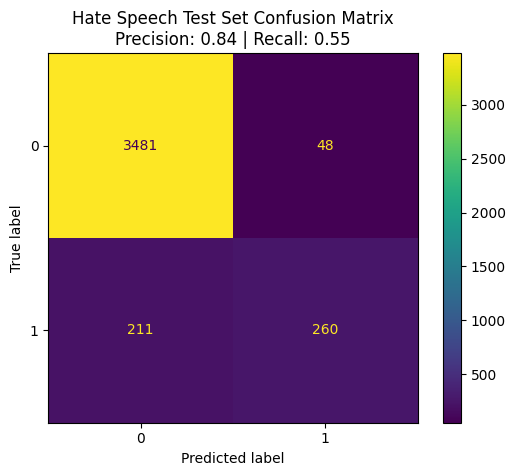

In [87]:
# Test set validation
confusion_matrix = metrics.confusion_matrix(eval_dict['val_labels'], eval_dict['val_preds'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])
cm_display.plot()

# get precision and recall
precision = metrics.precision_score(eval_dict['val_labels'], eval_dict['val_preds'])
recall = metrics.recall_score(eval_dict['val_labels'], eval_dict['val_preds'])

# plot
plt.title(f'Hate Speech Test Set Confusion Matrix\nPrecision: {precision:.2f} | Recall: {recall:.2f}')
plt.savefig('hate_speech_cm.png', format='png', dpi=300)

plt.show()
